# Importar bibliotecas necessárias

In [1]:
# Bibliotecas para Manipulação e Análise de Dados
import pandas as pd  
import numpy as np  

# Bibliotecas para Visualização de Dados ---
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas de Machine Learning 
import xgboost as xgb  # Implementação otimizada do algoritmo de gradient boosting.

# Utilitários do Python
import warnings
import datetime
from datetime import datetime
import os

# Módulos do Scikit-learn para Preparação e Avaliação de Modelos
from sklearn.model_selection import (
    GridSearchCV,  # Para otimização de hiperparâmetros através de busca em grade com validação cruzada.
    StratifiedKFold,  # Estratégia de validação cruzada que mantém a proporção das classes em cada fold.
    cross_val_score  # Para avaliar a pontuação de um modelo usando validação cruzada.
)
from sklearn.preprocessing import StandardScaler  # Para padronizar os dados (remover a média e escalar para variância unitária).
from sklearn.pipeline import Pipeline  # Para encadear múltiplos passos de processamento e modelagem.
from imblearn.over_sampling import SMOTE  # Técnica para lidar com dados desbalanceados, criando amostras sintéticas da classe minoritária.

# Algoritmos de Classificação

# Modelos de Ensemble
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Modelos baseados em Vetores de Suporte (SVM)
from sklearn.svm import SVC, LinearSVC

# Modelo baseado em vizinhos
from sklearn.neighbors import KNeighborsClassifier

# Modelos Lineares
from sklearn.linear_model import (
    LogisticRegression,  # Regressão Logística
    Perceptron,  # Perceptron
    SGDClassifier,  # Implementa modelos lineares com otimização por Gradiente Descendente Estocástico.
    RidgeClassifier,  # Classificador que usa regressão Ridge.
    PassiveAggressiveClassifier  # Algoritmo de aprendizado online.
)

# Modelo de Árvore de Decisão
from sklearn.tree import DecisionTreeClassifier

# Rede Neural
from sklearn.neural_network import MLPClassifier  # Multi-layer Perceptron (Rede Neural Artificial).

# Métricas para Avaliação de Performance
from sklearn.metrics import (
    accuracy_score,  # Calcula a acurácia do modelo
    precision_recall_fscore_support,  # Calcula precisão, recall, F1-score e suporte
    roc_auc_score,  # Calcula a área sob a curva ROC (AUC)
    confusion_matrix,  # Gera a matriz de confusão
    roc_curve,  # Calcula a curva ROC
    average_precision_score  # Calcula a precisão média (AP)
)

# Configuração de Avisos
warnings.filterwarnings('ignore') 

# Funções de Análise e Modelagem

In [2]:
# Função para carregar e converter os dados
def carregar_e_converter_dados():
    """
    Carrega os dados de treino e teste, converte a variável alvo para um
    formato de classificação binária e separa as features do alvo.
    """
    # Inicia um bloco try-except para capturar e lidar com possíveis erros durante a execução.
    try:
        # Verifica se os arquivos CSV de treino e teste existem no diretório atual.
        # A função os.path.exists() retorna True se o caminho existir.
        if not os.path.exists('heart_train_processed.csv') or not os.path.exists('heart_test_processed.csv'):
            # Se um ou ambos os arquivos não forem encontrados, exibe uma mensagem de erro.
            print("Erro: Arquivos de dados 'heart_train_processed.csv' ou 'heart_test_processed.csv' não encontrados.")
            print("Por favor, certifique-se de que os arquivos estão no mesmo diretório que o script.")
            # Retorna quatro valores None para indicar que a operação falhou.
            return None, None, None, None

        # Carrega os dados de treino e teste em DataFrames do pandas.
        train_df = pd.read_csv('heart_train_processed.csv')
        test_df = pd.read_csv('heart_test_processed.csv')

        # Transformação da Variável Alvo ---
        # Converte a coluna 'num_reag' para um problema de classificação binária.
        # A condição (df['num_reag'] > 0) cria uma série de valores Booleanos (True/False).
        # .astype(int) converte True para 1 (presença de doença) e False para 0 (ausência de doença).
        train_df['num_reag'] = (train_df['num_reag'] > 0).astype(int)
        test_df['num_reag'] = (test_df['num_reag'] > 0).astype(int)

        # Separação de Features (variáveis independentes) e Target (variável alvo)
        # Cria o conjunto de features (X_train) removendo a coluna alvo 'num_reag' do DataFrame de treino.
        X_train = train_df.drop('num_reag', axis=1)
        # Cria o conjunto alvo (y_train) selecionando apenas a coluna 'num_reag'.
        y_train = train_df['num_reag']
        
        # Repete o mesmo processo para o conjunto de teste.
        X_test = test_df.drop('num_reag', axis=1)
        y_test = test_df['num_reag']

        # Retorna os quatro conjuntos de dados processados.
        return X_train, y_train, X_test, y_test

    # Captura qualquer outra exceção que possa ocorrer durante o carregamento ou processamento.
    except Exception as e:
        # Imprime uma mensagem de erro informando a exceção específica que ocorreu.
        print(f"Erro ao carregar ou processar os dados: {e}")
        # Retorna None para todas as variáveis para sinalizar a falha.
        return None, None, None, None

In [3]:
# Função para obter os classificadores e parametros binários
def obter_classificadores_e_parametros_binarios(abordagem, y_train, usar_otimizacao=True):
    """
    Define e retorna um dicionário de classificadores e, opcionalmente,
    um dicionário com seus respectivos grids de hiperparâmetros para otimização.
    A função pode ajustar os classificadores para lidar com classes desbalanceadas.
    """
    # Dicionário contendo instâncias dos modelos de classificação a serem utilizados.
    # 'random_state=42' é usado para garantir que os resultados sejam reprodutíveis.
    # Parâmetros específicos como 'max_iter', 'use_label_encoder' e 'dual' são definidos
    # para garantir a convergência ou compatibilidade com as versões das bibliotecas.
    base_classificadores = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'SVM': SVC(random_state=42, probability=True), # probability=True é necessário para calcular AUC-PR
        'KNN': KNeighborsClassifier(),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'MLP': MLPClassifier(random_state=42, max_iter=1000),
        'Perceptron': Perceptron(random_state=42),
        'LinearSVC': LinearSVC(random_state=42, dual='auto'),
        'SGDClassifier': SGDClassifier(random_state=42),
        'RidgeClassifier': RidgeClassifier(random_state=42),
        'PassiveAggressiveClassifier': PassiveAggressiveClassifier(random_state=42)
    }

    # Dicionário contendo os hiperparâmetros a serem testados para cada classificador durante a otimização (GridSearch).
    # O prefixo 'classifier__' é usado para especificar que o parâmetro pertence ao estimador
    # dentro de um Pipeline do Scikit-learn.
    base_param_grids = {
        'Random Forest': {'classifier__n_estimators': [50, 100], 'classifier__max_depth': [5, 10]},
        'SVM': {'classifier__C': [0.1, 1.0], 'classifier__kernel': ['rbf', 'linear']},
        'KNN': {'classifier__n_neighbors': [3, 5, 7], 'classifier__weights': ['uniform', 'distance']},
        'Logistic Regression': {'classifier__C': [0.1, 1.0, 10.0], 'classifier__solver': ['liblinear', 'lbfgs']},
        'Decision Tree': {'classifier__max_depth': [5, 10, None], 'classifier__min_samples_split': [2, 5]},
        'XGBoost': {'classifier__n_estimators': [50, 100], 'classifier__learning_rate': [0.01, 0.1], 'classifier__max_depth': [3, 5]},
        'Gradient Boosting': {'classifier__n_estimators': [50, 100], 'classifier__learning_rate': [0.01, 0.1], 'classifier__max_depth': [3, 5]},
        'MLP': {'classifier__hidden_layer_sizes': [(50,), (100,)], 'classifier__alpha': [0.0001, 0.001]},
        'Perceptron': {'classifier__eta0': [0.0001, 0.001], 'classifier__max_iter': [1000, 2000]},
        'LinearSVC': {'classifier__C': [0.1, 1.0, 10.0]},
        'SGDClassifier': {'classifier__loss': ['hinge', 'log_loss'], 'classifier__alpha': [0.0001, 0.001]},
        'RidgeClassifier': {'classifier__alpha': [1.0, 10.0, 100.0]},
        'PassiveAggressiveClassifier': {'classifier__C': [0.5, 1.0], 'classifier__max_iter': [1000, 2000]}
    }

    # Cria cópias dos dicionários base para evitar modificar os originais em chamadas futuras da função.
    classificadores = base_classificadores.copy()
    # Se 'usar_otimizacao' for True, copia o grid de parâmetros. Caso contrário, define como None.
    param_grids = base_param_grids.copy() if usar_otimizacao else None

    # Verifica se a abordagem para lidar com dados desbalanceados é a "Ponderação de Classe".
    if abordagem == "Ponderação de Classe":
        # Itera sobre os classificadores que suportam o parâmetro 'class_weight'.
        for clf_name in ['Random Forest', 'SVM', 'Logistic Regression', 'Decision Tree', 'Perceptron', 'SGDClassifier', 'RidgeClassifier', 'PassiveAggressiveClassifier']:
            if clf_name in classificadores:
                # O parâmetro 'class_weight="balanced"' ajusta automaticamente os pesos das classes
                # de forma inversamente proporcional à sua frequência nos dados de treino.
                classificadores[clf_name].set_params(class_weight='balanced')

        # O XGBoost usa um parâmetro diferente ('scale_pos_weight').
        # Calculamos o peso para a classe positiva (1) como a razão entre o número de amostras
        # da classe negativa (0) e o número de amostras da classe positiva (1).
        pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
        classificadores['XGBoost'].set_params(scale_pos_weight=pos_weight)

    # Se a otimização de hiperparâmetros não for usada, define um valor padrão razoável
    # para o número de estimadores do RandomForest, para garantir uma performance base adequada.
    if not usar_otimizacao:
        classificadores['Random Forest'].set_params(n_estimators=100)

    # Retorna o dicionário de classificadores configurados e o dicionário de grids de parâmetros (ou None).
    return classificadores, param_grids

In [4]:
# Função para aplicar técnica SMOTE para lifar com o desbalanceamento de classes
def aplicar_smote_binario(X_train, y_train):
    """
    Aplica a técnica SMOTE (Synthetic Minority Over-sampling Technique)
    nos dados de treino para lidar com o desbalanceamento de classes.
    """
    # Cria uma instância do algoritmo SMOTE.
    # 'random_state=42' garante que a geração de amostras sintéticas seja sempre a mesma,
    # tornando o resultado reprodutível.
    # 'k_neighbors=5' define que 5 vizinhos mais próximos serão considerados ao criar
    # uma nova amostra sintética para a classe minoritária.
    smote = SMOTE(random_state=42, k_neighbors=5)

    # Aplica o SMOTE aos dados de treino (X_train, y_train).
    # O método 'fit_resample' aprende com os dados e depois os reamostra,
    # criando novas amostras sintéticas para a classe minoritária até que
    # o número de amostras em ambas as classes seja igual.
    X_reamostrado, y_reamostrado = smote.fit_resample(X_train, y_train)

    # Retorna os novos conjuntos de features e de alvo, agora balanceados.
    return X_reamostrado, y_reamostrado

In [5]:
# Função para otimização de hiperparâmetros dos classificadores 
def otimizar_com_gridsearch(classificadores, param_grids, X_train, y_train, cv_folds=3):
    """
    Realiza a otimização de hiperparâmetros para uma lista de classificadores
    usando GridSearchCV e retorna os melhores modelos encontrados.
    """
    # Dicionário para armazenar o melhor estimador (modelo treinado com os melhores parâmetros) para cada classificador.
    modelos_otimizados = {}
    # Dicionário para armazenar os resultados da otimização (melhor score e melhores parâmetros).
    resultados_otimizacao = {}

    # Obtém o número total de classificadores para exibir o progresso.
    total = len(classificadores)
    # Itera sobre o dicionário de classificadores, obtendo o nome e o objeto de cada um.
    # 'enumerate' é usado para obter um contador (i) junto com os itens.
    for i, (nome, classificador) in enumerate(classificadores.items()):
        print(f'Otimizando ({i+1}/{total}): {nome}')
        
        # Inicia um bloco try-except para lidar com possíveis erros durante a otimização de um modelo específico.
        try:
            # Cria um Pipeline, que encadeia transformações e um estimador.
            # 'scaler': Padroniza os dados (essencial para muitos algoritmos).
            # 'classifier': O modelo de machine learning a ser treinado.
            pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', classificador)])

            # Alguns modelos (ex: RidgeClassifier, LinearSVC) não possuem o método 'predict_proba',
            # que é necessário para calcular a métrica 'roc_auc'.
            models_without_proba = ['RidgeClassifier', 'PassiveAggressiveClassifier', 'LinearSVC', 'Perceptron']
            # Define a métrica de avaliação: usa 'accuracy' para os modelos sem 'predict_proba'
            # e 'roc_auc' para os demais, que é uma métrica mais robusta para classificação binária.
            scoring_metric = 'accuracy' if nome in models_without_proba else 'roc_auc'

            # Configura o GridSearchCV.
            # - pipeline: O objeto a ser otimizado.
            # - param_grids[nome]: O dicionário com os hiperparâmetros a serem testados para o classificador atual.
            # - cv: Número de dobras (folds) para a validação cruzada.
            # - scoring: A métrica usada para escolher o melhor modelo.
            # - n_jobs=-1: Utiliza todos os núcleos de CPU disponíveis para acelerar a busca.
            # - verbose=0: Suprime as mensagens de log detalhadas do processo.
            grid_search = GridSearchCV(pipeline, param_grids[nome], cv=cv_folds, scoring=scoring_metric, n_jobs=-1, verbose=0)
            
            # Executa a busca em grade. O GridSearchCV treinará o pipeline com todas as combinações
            # de parâmetros e encontrará a melhor.
            grid_search.fit(X_train, y_train)

            # Armazena o melhor pipeline (scaler + classificador com os melhores parâmetros) encontrado.
            modelos_otimizados[nome] = grid_search.best_estimator_
            # Armazena os detalhes da melhor performance: o score e os parâmetros que o geraram.
            resultados_otimizacao[nome] = {'best_score': grid_search.best_score_, 'best_params': grid_search.best_params_}
        
        # Se ocorrer qualquer erro durante a otimização de um modelo
        except Exception as e:
            # imprime uma mensagem de erro informando qual modelo falhou e o motivo.
            print(f"  -> Erro na otimização de {nome}: {e}")
            # Armazena o modelo original (não otimizado) dentro de um pipeline para manter a consistência.
            modelos_otimizados[nome] = Pipeline([('scaler', StandardScaler()), ('classifier', classificador)])
            # Registra que a otimização falhou, com score 0 e sem parâmetros.
            resultados_otimizacao[nome] = {'best_score': 0, 'best_params': {}}

    # Retorna os dois dicionários: um com os modelos prontos para uso e outro com os resultados da busca.
    return modelos_otimizados, resultados_otimizacao

In [6]:
# Função para executar validação cruzada 
def executar_validacao_cruzada_binaria(modelos, X_train, y_train, cv_folds=5):
    """
    Executa a validação cruzada para um conjunto de modelos e calcula
    métricas de performance (Acurácia, AUC, F1-Score).
    """
    # Dicionário para armazenar os resultados da validação cruzada para cada modelo.
    resultados_cv = {}
    
    # Define a estratégia de validação cruzada.
    # StratifiedKFold é usado para garantir que cada 'fold' (dobra) tenha a mesma proporção
    # de amostras de cada classe que o conjunto de dados original. Essencial para dados desbalanceados.
    # - n_splits: Número de dobras (folds) em que os dados serão divididos.
    # - shuffle=True: Embaralha os dados antes de dividi-los.
    # - random_state=42: Garante que o embaralhamento seja o mesmo em todas as execuções, para reprodutibilidade.
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    # Obtém o número total de modelos para exibir o progresso.
    total = len(modelos)
    # Itera sobre o dicionário de modelos, obtendo o nome e o objeto de cada um.
    for i, (nome, modelo) in enumerate(modelos.items()):
        print(f'Validação cruzada ({i+1}/{total}): {nome}')
        
        # Inicia um bloco try-except para lidar com erros que possam ocorrer durante a validação de um modelo específico.
        try:
            # Calcula os scores de acurácia para cada fold da validação cruzada.
            # 'cross_val_score' treina e avalia o modelo 'cv_folds' vezes.
            # 'n_jobs=-1' utiliza todos os processadores disponíveis para acelerar o cálculo.
            accuracy_scores = cross_val_score(modelo, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
            
            # Calcula os scores F1 para cada fold.
            f1_scores = cross_val_score(modelo, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
            
            # Inicia um bloco try-except aninhado especificamente para a métrica AUC,
            # pois alguns modelos não suportam o cálculo de probabilidades ('predict_proba').
            try:
                # Tenta calcular os scores de AUC (Area Under the Curve) para cada fold.
                auc_scores = cross_val_score(modelo, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
            except Exception:
                # Se o cálculo de AUC falhar, cria um array de zeros para os scores de AUC.
                # Isso permite que o restante do código continue a ser executado sem erros.
                auc_scores = np.array([0.0] * cv.get_n_splits())

            # Armazena a média e o desvio padrão das métricas calculadas em todos os folds.
            # A média dá uma estimativa da performance do modelo, enquanto o desvio padrão
            # indica a variabilidade (estabilidade) dessa performance.
            resultados_cv[nome] = {
                'Accuracy_Mean': accuracy_scores.mean(), 'Accuracy_Std': accuracy_scores.std(),
                'AUC_Mean': auc_scores.mean(), 'AUC_Std': auc_scores.std(),
                'F1_Mean': f1_scores.mean(), 'F1_Std': f1_scores.std()
            }
        
        # Se ocorrer um erro geral durante a validação cruzada de um modelo
        except Exception as e:
            # Imprime uma mensagem de erro indicando o modelo e a causa.
            print(f"  -> Erro na validação cruzada de {nome}: {e}")
            # Registra o modelo com métricas zeradas para indicar a falha.
            resultados_cv[nome] = {
                'Accuracy_Mean': 0, 'Accuracy_Std': 0, 'AUC_Mean': 0, 'AUC_Std': 0, 'F1_Mean': 0, 'F1_Std': 0
            }

    # Retorna o dicionário com os resultados consolidados da validação cruzada.
    return resultados_cv

In [7]:
# Função para treinar e avaliar os modelos 
def treinar_e_avaliar_binario(modelos, X_train, y_train, X_test, y_test):
    """
    Treina cada modelo com o conjunto de treino completo e avalia sua performance
    no conjunto de teste, retornando um dicionário com diversas métricas.
    """
    # Dicionário para armazenar os resultados da avaliação de cada modelo no conjunto de teste.
    resultados = {}
    
    # Obtém o número total de modelos para exibir o progresso.
    total = len(modelos)
    # Itera sobre o dicionário de modelos, obtendo o nome e o objeto de cada um.
    for i, (nome, modelo) in enumerate(modelos.items()):
        print(f'Avaliando no conjunto de teste ({i+1}/{total}): {nome}')
        
        # Inicia um bloco try-except para lidar com erros durante o treino ou avaliação de um modelo.
        try:
            # Treina o modelo utilizando todos os dados de treino.
            # O método 'fit' ajusta os parâmetros do modelo aos dados.
            modelo.fit(X_train, y_train)
            
            # Realiza predições de classe (0 ou 1) para os dados de teste.
            y_pred = modelo.predict(X_test)
            
            # Inicializa a variável para armazenar os scores de probabilidade ou confiança.
            y_scores = None

            # Obtenção dos Scores para Cálculo da AUC
            # Verifica se o modelo possui o método 'predict_proba', que retorna a probabilidade de cada classe.
            if hasattr(modelo, "predict_proba"):
                # Se sim, obtém as probabilidades e seleciona apenas a da classe positiva (coluna 1).
                y_scores = modelo.predict_proba(X_test)[:, 1]
            # Se não tiver 'predict_proba', verifica se possui 'decision_function' (comum em SVMs).
            elif hasattr(modelo, "decision_function"):
                # 'decision_function' retorna a distância da amostra ao hiperplano de separação,
                # que serve como um score de confiança.
                y_scores = modelo.decision_function(X_test)

            # Cálculo das Métricas de Performance
            # Calcula a AUC. Se 'y_scores' foi obtido, calcula a métrica.
            # Caso contrário (para modelos sem 'predict_proba' ou 'decision_function'),
            # atribui 0.5, que é o valor de um classificador aleatório.
            auc = roc_auc_score(y_test, y_scores) if y_scores is not None else 0.5
            
            # Calcula Precisão, Recall e F1-Score.
            # 'average='binary'' especifica que as métricas devem ser calculadas para a classe positiva.
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

            # Armazena todas as métricas calculadas no dicionário de resultados.
            resultados[nome] = {
                'Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'AUC': auc,
                'Probabilities': y_scores,  # Armazena os scores brutos para análises futuras (ex: curva ROC)
                'Confusion_Matrix': confusion_matrix(y_test, y_pred) # Matriz de confusão [VN, FP], [FN, VP]
            }
        
        # Se ocorrer um erro durante o processo para um modelo
        except Exception as e:
            # Imprime uma mensagem de erro e continua para o próximo modelo.
            print(f"  -> Erro ao treinar/avaliar {nome}: {e}")

    # Retorna o dicionário completo com os resultados da performance de todos os modelos.
    return resultados

# Funções de Visualização

In [8]:
# Função para exibir a distribuição das classes
def exibir_distribuicao_classes_binaria(y_train_original, y_train_processado, abordagem):
    """Exibe distribuição das classes binárias com Matplotlib"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    def plot_bar(ax, data, title):
        contagens = pd.Series(data).value_counts().sort_index()
        labels = ['Sem Doença (0)', 'Com Doença (1)']
        barras = ax.bar(labels, contagens.values, color=['lightblue', 'lightcoral'])
        ax.set_ylabel('Número de Amostras')
        ax.set_title(title)
        for bar in barras:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom')

    plot_bar(ax1, y_train_original, 'Distribuição Original das Classes')
    plot_bar(ax2, y_train_processado, f'Distribuição Após {abordagem}')

    plt.tight_layout()
    plt.show()

In [9]:
# Função para exibir os resultados de otimização de hiperparâmetros
def exibir_resultados_otimizacao(resultados_otimizacao):
    """Exibe resultados da otimização no console"""
    print("\n" + "="*50)
    print("Resultados da Otimização de Hiperparâmetros")
    print("="*50)

    opt_df = pd.DataFrame({
        'Modelo': list(resultados_otimizacao.keys()),
        'Melhor Score (CV)': [r['best_score'] for r in resultados_otimizacao.values()]
    }).sort_values('Melhor Score (CV)', ascending=False).reset_index(drop=True)

    print("\n--- Melhores Scores ---\n")
    print(opt_df.to_string())

    print("\n--- Melhores Hiperparâmetros ---")
    for nome, resultado in resultados_otimizacao.items():
        print(f"\nModelo: {nome}")
        print(f"  Parâmetros: {resultado['best_params']}")
    print("\n")

In [10]:
# Função para exibir os resultados da validação cruzada
def exibir_resultados_cv_binario(resultados_cv):
    """Exibe resultados da validação cruzada no console e em gráfico"""
    print("\n" + "="*50)
    print("Resultados da Validação Cruzada")
    print("="*50 + "\n")

    cv_df = pd.DataFrame({
        'Modelo': list(resultados_cv.keys()),
        'Acurácia': [r['Accuracy_Mean'] for r in resultados_cv.values()],
        'AUC': [r['AUC_Mean'] for r in resultados_cv.values()],
        'F1-Score': [r['F1_Mean'] for r in resultados_cv.values()],
    }).sort_values('AUC', ascending=False).reset_index(drop=True)

    print(cv_df.round(4).to_string())

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    cv_df_sorted = cv_df.sort_values('Acurácia')
    ax1.barh(cv_df_sorted['Modelo'], cv_df_sorted['Acurácia'], color='skyblue')
    ax1.set_title('Acurácia Média (CV)')

    cv_df_sorted = cv_df.sort_values('AUC')
    ax2.barh(cv_df_sorted['Modelo'], cv_df_sorted['AUC'], color='lightcoral')
    ax2.set_title('AUC Médio (CV)')

    cv_df_sorted = cv_df.sort_values('F1-Score')
    ax3.barh(cv_df_sorted['Modelo'], cv_df_sorted['F1-Score'], color='lightgreen')
    ax3.set_title('F1-Score Médio (CV)')

    plt.tight_layout()
    plt.show()

In [11]:
# Função para exibir matriz de confusão
def exibir_matrizes_confusao_binaria(resultados):
    """Exibe matrizes de confusão"""
    print("\n" + "="*50)
    print("Matrizes de Confusão (Conjunto de Teste)")
    print("="*50 + "\n")

    modelos = list(resultados.keys())
    num_modelos = len(modelos)
    cols = 3
    rows = (num_modelos + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4.5))
    axes = axes.flatten()

    for i, model_name in enumerate(modelos):
        cm = resultados[model_name]['Confusion_Matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                    xticklabels=['Sem Doença', 'Com Doença'],
                    yticklabels=['Sem Doença', 'Com Doença'])
        axes[i].set_title(f'{model_name}')
        axes[i].set_xlabel('Predição')
        axes[i].set_ylabel('Real')

    # Esconde eixos não utilizados
    for i in range(num_modelos, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

In [12]:
# Função para exibir curva de ROC
def exibir_curvas_roc(resultados, y_test):
    """Exibe curvas ROC para todos os modelos"""
    print("\n" + "="*50)
    print("Exibindo Curvas ROC")
    print("="*50)

    fig, ax = plt.subplots(figsize=(12, 4))
    colors = plt.cm.get_cmap('tab20', len(resultados))

    for i, (nome, resultado) in enumerate(resultados.items()):
        if resultado['Probabilities'] is not None:
            fpr, tpr, _ = roc_curve(y_test, resultado['Probabilities'])
            auc = resultado['AUC']
            ax.plot(fpr, tpr, color=colors(i), linewidth=2, label=f'{nome} (AUC = {auc:.3f})')

    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1, label='Aleatório')
    ax.set_xlabel('Taxa de Falsos Positivos')
    ax.set_ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)')
    ax.set_title('Curvas ROC - Comparação de Modelos')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [13]:
# Função para exibir quatro com resultados de avaliação comparativos 
def exibir_resultados_comparativos_binarios(resultados):
    """Exibe tabela comparativa final"""
    print("\n" + "="*50)
    print("Comparação Final dos Modelos no Conjunto de Teste")
    print("="*50 + "\n")

    results_df = pd.DataFrame({
        'Modelo': list(resultados.keys()),
        'Acurácia': [r['Accuracy'] for r in resultados.values()],
        'Precisão': [r['Precision'] for r in resultados.values()],
        'Recall': [r['Recall'] for r in resultados.values()],
        'F1-Score': [r['F1-Score'] for r in resultados.values()],
        'AUC': [r['AUC'] for r in resultados.values()]
    }).sort_values('AUC', ascending=False).reset_index(drop=True)

    print(results_df.round(4).to_string())

    best_model = results_df.iloc[0]
    print("\n--- Destaques ---")
    print(f"Melhor Modelo (por AUC): {best_model['Modelo']} (AUC: {best_model['AUC']:.4f})")
    if best_model['Recall'] < 0.8:
        print(f"Atenção Médica: O melhor modelo tem recall de {best_model['Recall']:.3f}. Considere otimizar para maior sensibilidade.")
    else:
        print(f"Boa Sensibilidade: O modelo detecta {best_model['Recall']*100:.1f}% dos casos de doença.")

    return results_df

# Funções de Geração de Relatório

In [31]:
# Função para gerar relatório completo 
def gerar_e_salvar_relatorio_completo(resultados_teste, resultados_cv, resultados_otimizacao, abordagem, usar_otimizacao):
    """Gera um relatório completo em Markdown e salva em um arquivo."""
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    report_lines = [
        f"# Relatório Completo de Avaliação de Modelos\n",
        f"Gerado em: {now}\n",
        f"**Abordagem de Balanceamento:** {abordagem}\n",
        f"**Otimização de Hiperparâmetros:** {'Sim' if usar_otimizacao else 'Não'}\n",
        "---\n"
    ]

    # Resultados Finais no Teste
    results_df = exibir_resultados_comparativos_binarios(resultados_teste) # Reutiliza a função para criar o DF
    report_lines.append("##Resultados Finais no Conjunto de Teste\n")
    report_lines.append(results_df.to_markdown(index=False))
    report_lines.append("\n\n")

    # Resultados da Validação Cruzada
    cv_df = pd.DataFrame({
        'Modelo': list(resultados_cv.keys()),
        'Acurácia Média (CV)': [r['Accuracy_Mean'] for r in resultados_cv.values()],
        'AUC Médio (CV)': [r['AUC_Mean'] for r in resultados_cv.values()],
        'F1-Score Médio (CV)': [r['F1_Mean'] for r in resultados_cv.values()]
    }).sort_values('AUC Médio (CV)', ascending=False)
    report_lines.append("##Resultados da Validação Cruzada\n")
    report_lines.append(cv_df.to_markdown(index=False))
    report_lines.append("\n\n")

    # Hiperparâmetros
    if usar_otimizacao and resultados_otimizacao:
        report_lines.append("## Melhores Hiperparâmetros\n")
        for nome, resultado in resultados_otimizacao.items():
            report_lines.append(f"### {nome}\n")
            report_lines.append(f"```json\n{str(resultado['best_params'])}\n```\n")

    filename = f"relatorio_completo_{abordagem.replace(' ', '_').lower()}.md"
    with open(filename, "w", encoding="utf-8") as f:
        f.write("\n".join(report_lines))
    print(f"\nRelatório completo salvo em '{filename}'")

# CONFIGURAÇÕES DA ANÁLISE

In [32]:
# Altere estas variáveis para configurar a execução
ABORDAGEM = "Oversampling com SMOTE"  # Opções: "Ponderação de Classe", "Oversampling com SMOTE"
USAR_OTIMIZACAO = True               # Opções: True, False
CV_FOLDS_OPT = 3                     # Folds para otimização (GridSearch)  (divisão em 3 partes)
CV_FOLDS_FINAL = 5                   # Folds para validação final (divisão em 5 partes)

In [33]:
# Chama a função para carregar e processar os dados, desempacotando os resultados
X_train, y_train, X_test, y_test = carregar_e_converter_dados()

In [17]:
print("\nAnálise Binária de Doença Cardíaca")
print("\nComparação de Abordagens de Balanceamento com Otimização")
print("\nClasses: 0 (Sem doença) vs 1 (Presença de doença)")
print("-" * 50)
print("\nConfigurações da Execução:\n")
print(f"  - Abordagem de Balanceamento: {ABORDAGEM}")
print(f"  - Otimizar Hiperparâmetros: {'Sim' if USAR_OTIMIZACAO else 'Não'}")
print(f"  - Folds de Otimização: {CV_FOLDS_OPT if USAR_OTIMIZACAO else 'N/A'}")
print(f"  - Folds de Validação Final: {CV_FOLDS_FINAL}")
print("\n")


Análise Binária de Doença Cardíaca

Comparação de Abordagens de Balanceamento com Otimização

Classes: 0 (Sem doença) vs 1 (Presença de doença)
--------------------------------------------------

Configurações da Execução:

  - Abordagem de Balanceamento: Oversampling com SMOTE
  - Otimizar Hiperparâmetros: Sim
  - Folds de Otimização: 3
  - Folds de Validação Final: 5




In [18]:
# Aplica a abordagem de balanceamento
if ABORDAGEM == "Oversampling com SMOTE":
    print("\nProcessando: Aplicando SMOTE...")
    X_train_proc, y_train_proc = aplicar_smote_binario(X_train, y_train)
    print("SMOTE aplicado - classes balanceadas")
else: # Ponderação de Classe
    X_train_proc, y_train_proc = X_train, y_train
    print("\nProcessando: Usando Ponderação de Classe...")
    print("Ponderação de classe será configurada nos modelos.")


Processando: Aplicando SMOTE...
SMOTE aplicado - classes balanceadas


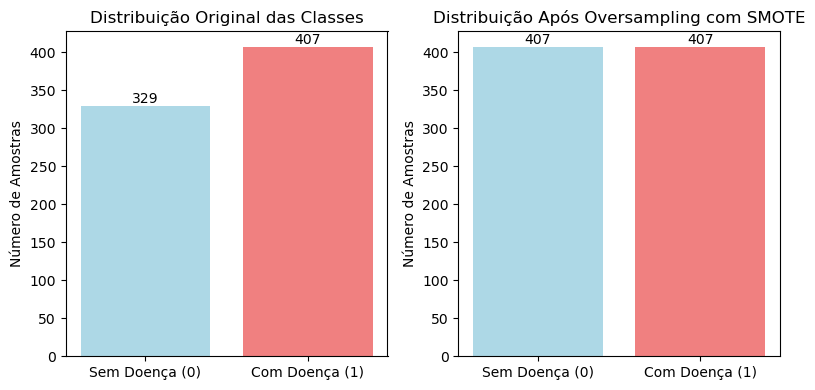

In [19]:
# Visualização e Preparação dos Modelos
# Chama a função para exibir a distribuição das classes antes e depois do processamento (ex: SMOTE).
exibir_distribuicao_classes_binaria(y_train, y_train_proc, ABORDAGEM)
# Chama a função obter os classificadores e parametros binários
classificadores, param_grids = obter_classificadores_e_parametros_binarios(ABORDAGEM, y_train, USAR_OTIMIZACAO)

In [21]:
# Inicializa um dicionário para guardar os modelos finais que serão usados na avaliação.
modelos_a_usar = {}
# Inicializa um dicionário para guardar os resultados da otimização, caso seja executada.
resultados_otimizacao = {}

In [22]:
# Verifica a variável de controle para decidir se a otimização de hiperparâmetros deve ser executada.
if USAR_OTIMIZACAO:
    # Chama a função para otimização de hiperparâmetros dos classificadores 
    modelos_otimizados, resultados_otimizacao = otimizar_com_gridsearch(
        classificadores, param_grids, X_train_proc, y_train_proc, CV_FOLDS_OPT
    )
    # Após a otimização, chama uma função para exibir os melhores parâmetros e scores encontrados.
    exibir_resultados_otimizacao(resultados_otimizacao)
    # Define que os modelos a serem usados para a próxima etapa são os modelos otimizados.
    modelos_a_usar = modelos_otimizados
else:
    # Caso a otimização não seja executada, informa o usuário.
    print("\nUsando configurações padrão dos modelos (sem otimização).")
    # Itera sobre os classificadores com suas configurações padrão.
    for nome, classificador in classificadores.items():
        # Para cada classificador, cria um Pipeline que primeiro padroniza os dados (Scaler)
        # e depois aplica o classificador. Isso garante que os dados sejam escalados
        # mesmo quando não há otimização, mantendo a consistência do processo.
        modelos_a_usar[nome] = Pipeline([('scaler', StandardScaler()), ('classifier', classificador)])

Otimizando (1/13): Random Forest
Otimizando (2/13): SVM
Otimizando (3/13): KNN
Otimizando (4/13): Logistic Regression
Otimizando (5/13): Decision Tree
Otimizando (6/13): XGBoost
Otimizando (7/13): Gradient Boosting
Otimizando (8/13): MLP
Otimizando (9/13): Perceptron
Otimizando (10/13): LinearSVC
Otimizando (11/13): SGDClassifier
Otimizando (12/13): RidgeClassifier
Otimizando (13/13): PassiveAggressiveClassifier

Resultados da Otimização de Hiperparâmetros

--- Melhores Scores ---

                         Modelo  Melhor Score (CV)
0                           SVM           0.889268
1           Logistic Regression           0.889144
2                 Random Forest           0.887891
3                 SGDClassifier           0.885027
4                           KNN           0.881078
5                       XGBoost           0.881067
6             Gradient Boosting           0.877983
7                           MLP           0.862401
8                 Decision Tree           0.812071
9  

Validação cruzada (1/13): Random Forest
Validação cruzada (2/13): SVM
Validação cruzada (3/13): KNN
Validação cruzada (4/13): Logistic Regression
Validação cruzada (5/13): Decision Tree
Validação cruzada (6/13): XGBoost
Validação cruzada (7/13): Gradient Boosting
Validação cruzada (8/13): MLP
Validação cruzada (9/13): Perceptron
Validação cruzada (10/13): LinearSVC
Validação cruzada (11/13): SGDClassifier
Validação cruzada (12/13): RidgeClassifier
Validação cruzada (13/13): PassiveAggressiveClassifier

Resultados da Validação Cruzada

                         Modelo  Acurácia     AUC  F1-Score
0                       XGBoost    0.8182  0.8987    0.8185
1                 Random Forest    0.8341  0.8973    0.8353
2                           KNN    0.8206  0.8950    0.8205
3             Gradient Boosting    0.8255  0.8940    0.8255
4           Logistic Regression    0.8071  0.8898    0.8075
5               RidgeClassifier    0.8071  0.8888    0.8060
6                     LinearSVC    0.80

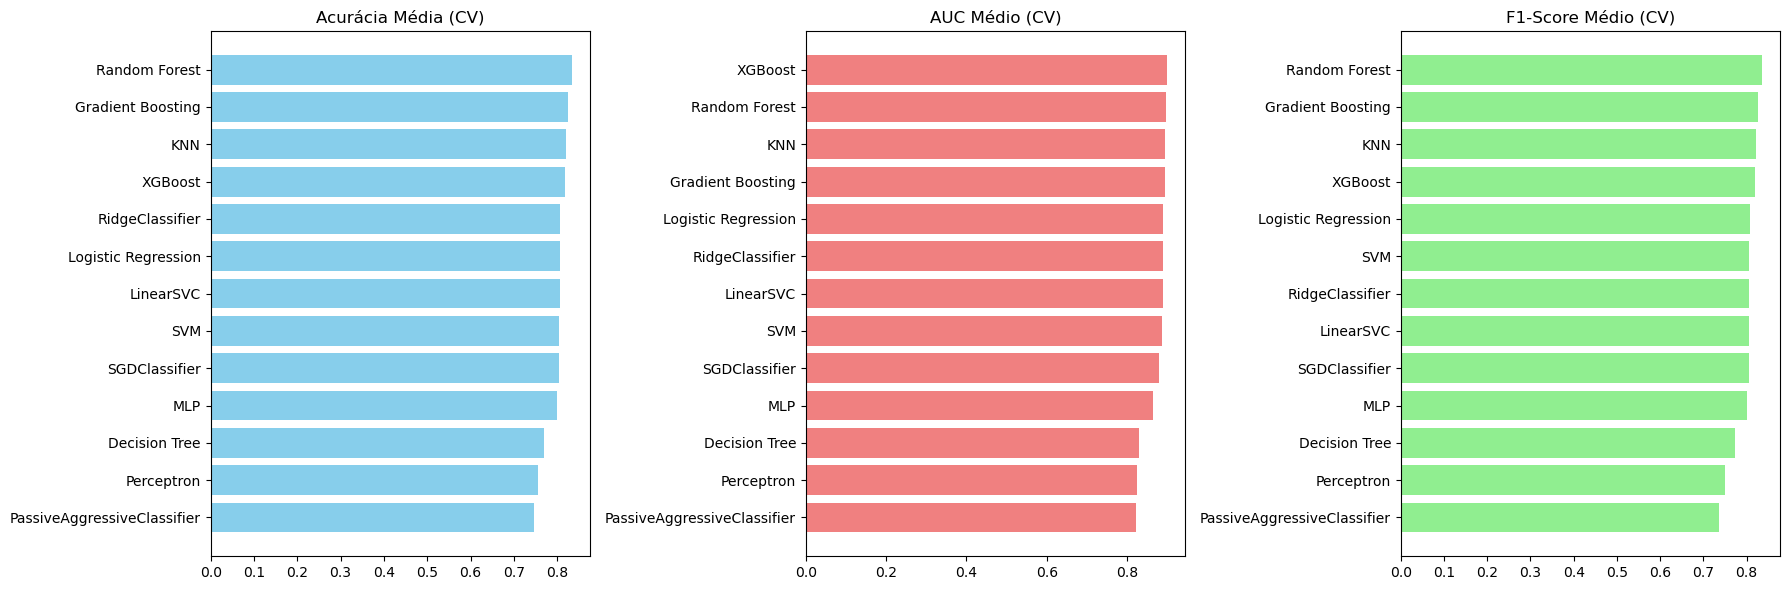

In [23]:
# Chama a função para executar a Validação Cruzada e Avaliação Final
resultados_cv = executar_validacao_cruzada_binaria(modelos_a_usar, X_train_proc, y_train_proc, CV_FOLDS_FINAL)
exibir_resultados_cv_binario(resultados_cv)

In [24]:
# Chama a função para treinar e avaliar os modelos 
resultados_teste = treinar_e_avaliar_binario(modelos_a_usar, X_train_proc, y_train_proc, X_test, y_test)

Avaliando no conjunto de teste (1/13): Random Forest
Avaliando no conjunto de teste (2/13): SVM
Avaliando no conjunto de teste (3/13): KNN
Avaliando no conjunto de teste (4/13): Logistic Regression
Avaliando no conjunto de teste (5/13): Decision Tree
Avaliando no conjunto de teste (6/13): XGBoost
Avaliando no conjunto de teste (7/13): Gradient Boosting
Avaliando no conjunto de teste (8/13): MLP
Avaliando no conjunto de teste (9/13): Perceptron
Avaliando no conjunto de teste (10/13): LinearSVC
Avaliando no conjunto de teste (11/13): SGDClassifier
Avaliando no conjunto de teste (12/13): RidgeClassifier
Avaliando no conjunto de teste (13/13): PassiveAggressiveClassifier



Matrizes de Confusão (Conjunto de Teste)



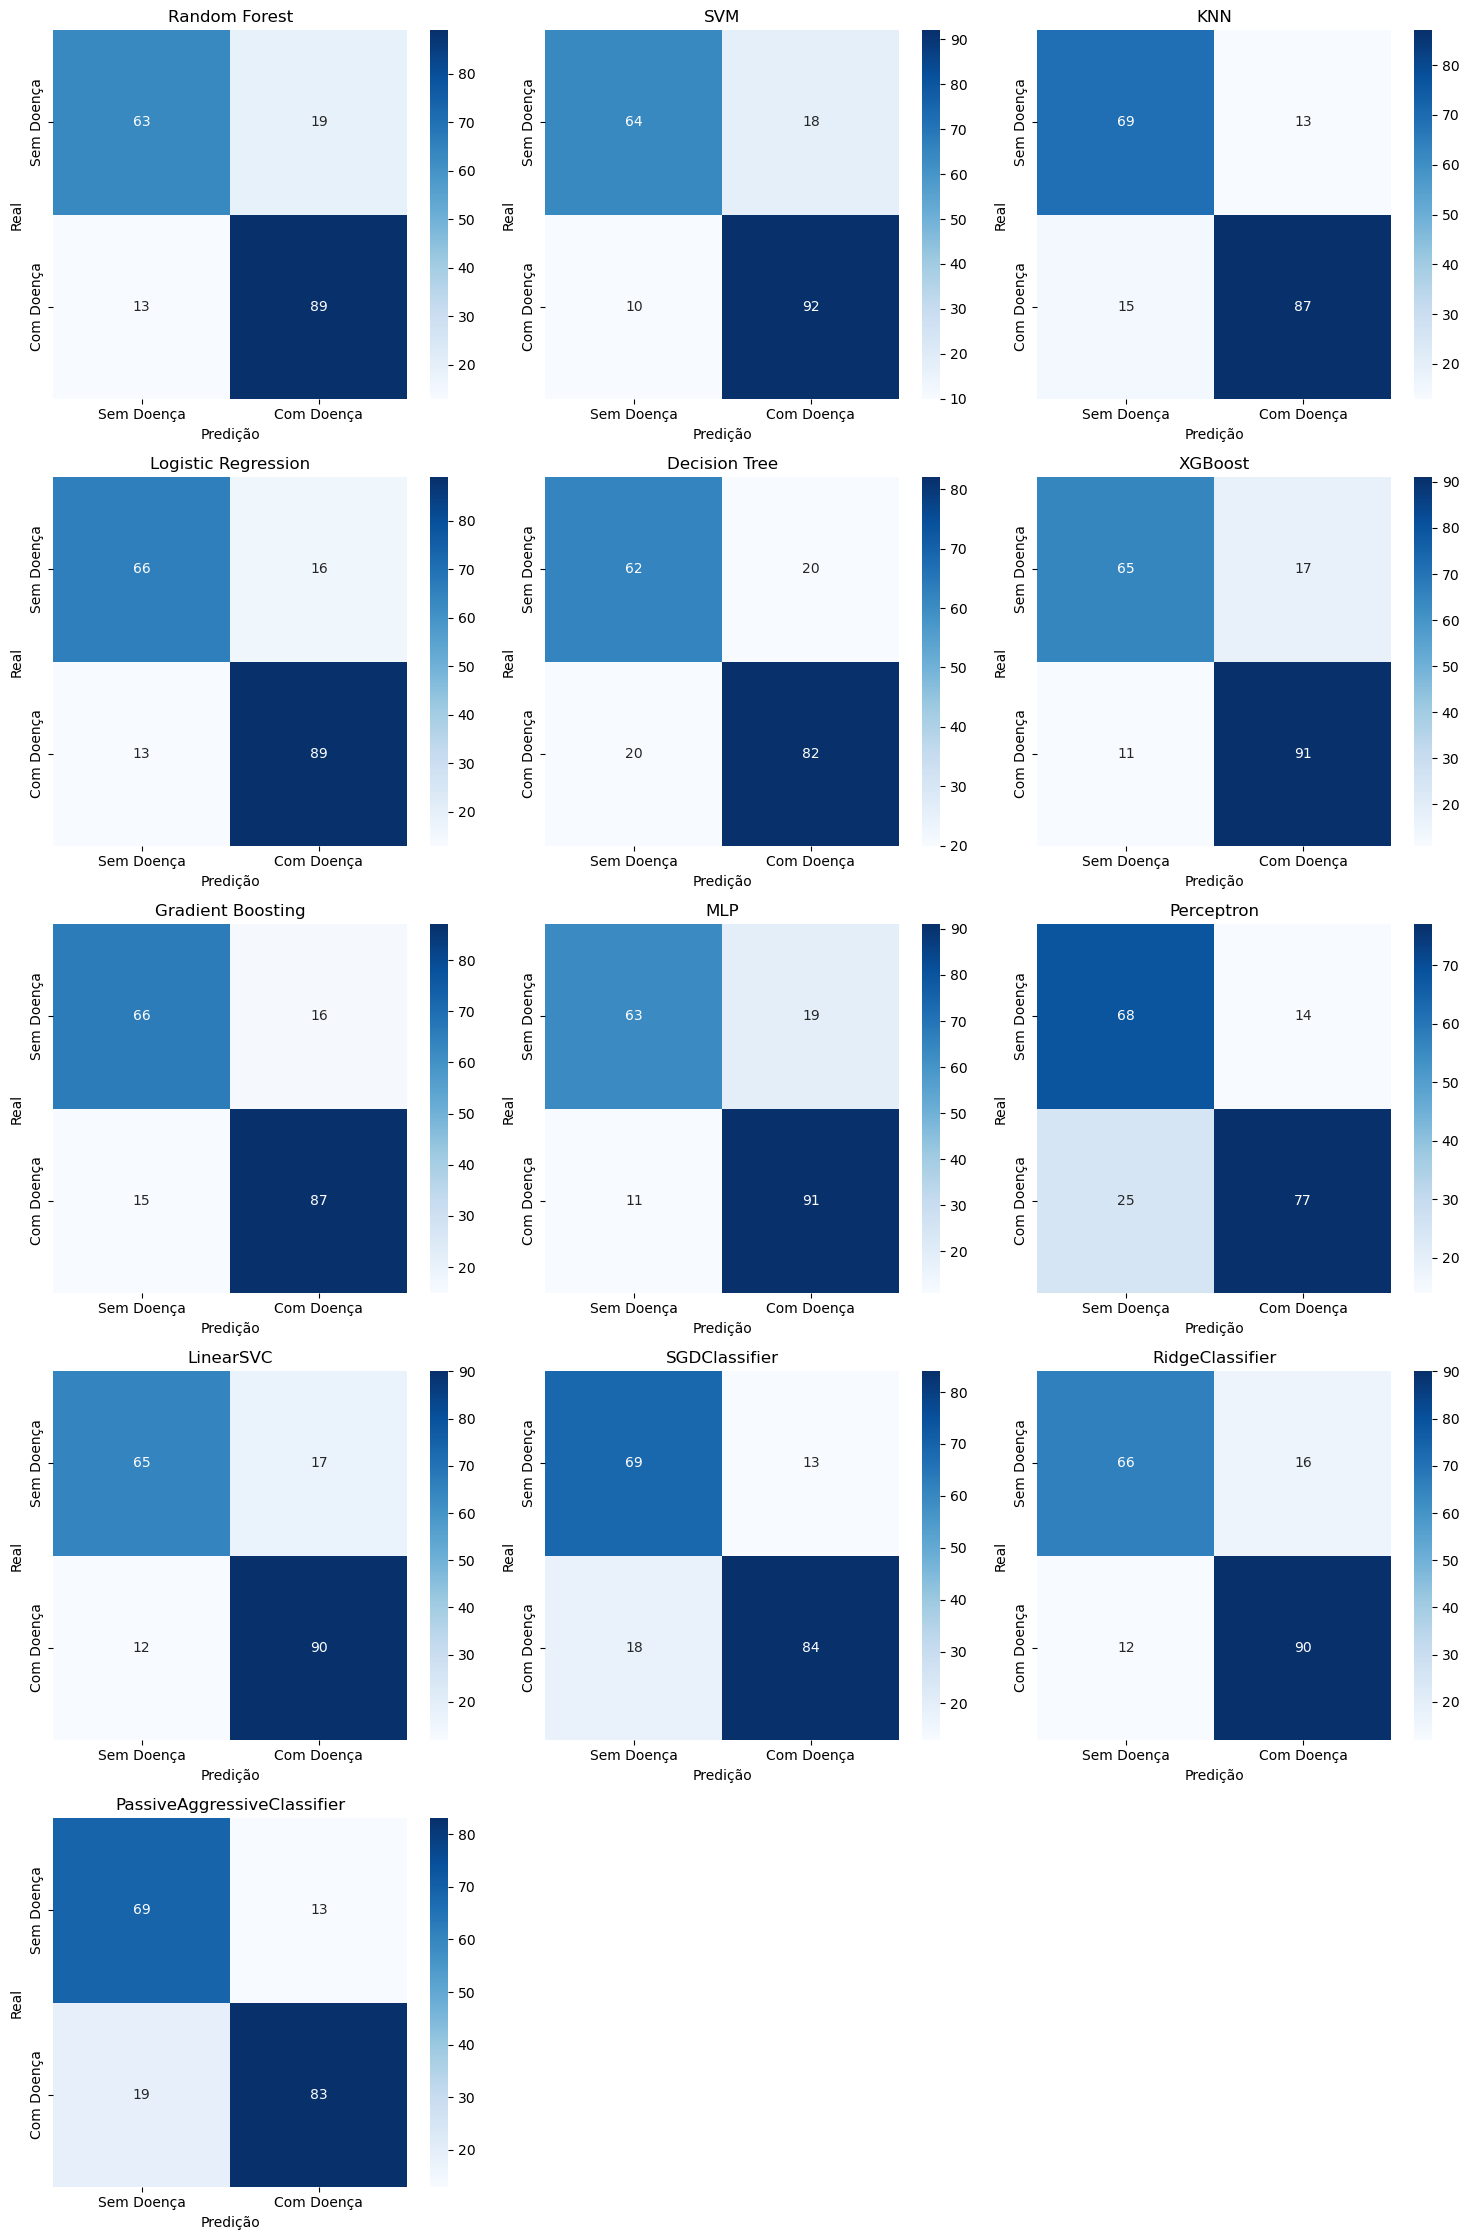

In [25]:
# Exibir matriz de confusão
exibir_matrizes_confusao_binaria(resultados_teste)


Exibindo Curvas ROC


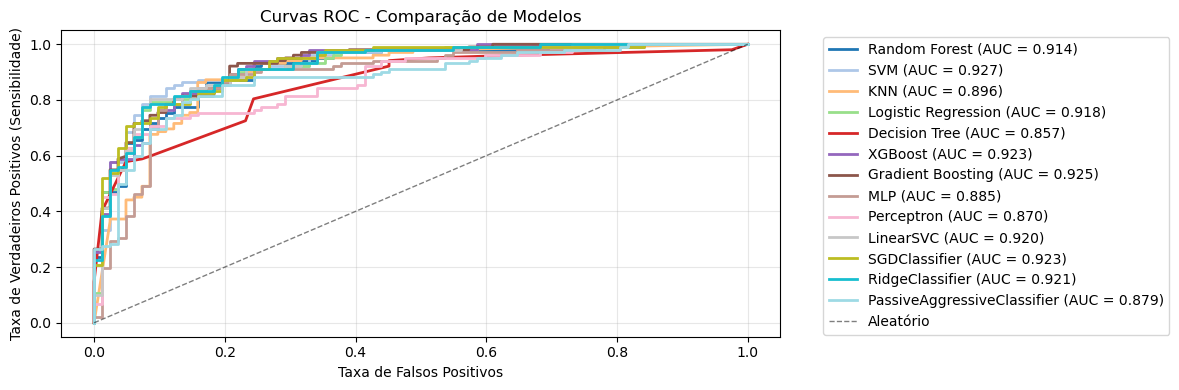

In [26]:
# Exibir curva de ROC
exibir_curvas_roc(resultados_teste, y_test)

In [27]:
# Exibir quadro comparativo
exibir_resultados_comparativos_binarios(resultados_teste)


Comparação Final dos Modelos no Conjunto de Teste

                         Modelo  Acurácia  Precisão  Recall  F1-Score     AUC
0                           SVM    0.8478    0.8364  0.9020    0.8679  0.9268
1             Gradient Boosting    0.8315    0.8447  0.8529    0.8488  0.9253
2                 SGDClassifier    0.8315    0.8660  0.8235    0.8442  0.9232
3                       XGBoost    0.8478    0.8426  0.8922    0.8667  0.9226
4               RidgeClassifier    0.8478    0.8491  0.8824    0.8654  0.9212
5                     LinearSVC    0.8424    0.8411  0.8824    0.8612  0.9199
6           Logistic Regression    0.8424    0.8476  0.8725    0.8599  0.9183
7                 Random Forest    0.8261    0.8241  0.8725    0.8476  0.9142
8                           KNN    0.8478    0.8700  0.8529    0.8614  0.8961
9                           MLP    0.8370    0.8273  0.8922    0.8585  0.8853
10  PassiveAggressiveClassifier    0.8261    0.8646  0.8137    0.8384  0.8785
11          

,Modelo,Acurácia,Precisão,Recall,F1-Score,AUC
0,SVM,0.847826,0.836364,0.901961,0.867925,0.926829
1,Gradient Boosting,0.831522,0.844660,0.852941,0.848780,0.925335
2,SGDClassifier,0.831522,0.865979,0.823529,0.844221,0.923242
3,XGBoost,0.847826,0.842593,0.892157,0.866667,0.922645
4,RidgeClassifier,0.847826,0.849057,0.882353,0.865385,0.921210
5,LinearSVC,0.842391,0.841121,0.882353,0.861244,0.919895
6,Logistic Regression,0.842391,0.847619,0.872549,0.859903,0.918341
7,Random Forest,0.826087,0.824074,0.872549,0.847619,0.914156
8,KNN,0.847826,0.870000,0.852941,0.861386,0.896102
9,MLP,0.836957,0.827273,0.892157,0.858491,0.885342


In [34]:
# Geração do relatório final
gerar_e_salvar_relatorio_completo(resultados_teste, resultados_cv, resultados_otimizacao, ABORDAGEM, USAR_OTIMIZACAO)


Comparação Final dos Modelos no Conjunto de Teste

                         Modelo  Acurácia  Precisão  Recall  F1-Score     AUC
0                           SVM    0.8478    0.8364  0.9020    0.8679  0.9268
1             Gradient Boosting    0.8315    0.8447  0.8529    0.8488  0.9253
2                 SGDClassifier    0.8315    0.8660  0.8235    0.8442  0.9232
3                       XGBoost    0.8478    0.8426  0.8922    0.8667  0.9226
4               RidgeClassifier    0.8478    0.8491  0.8824    0.8654  0.9212
5                     LinearSVC    0.8424    0.8411  0.8824    0.8612  0.9199
6           Logistic Regression    0.8424    0.8476  0.8725    0.8599  0.9183
7                 Random Forest    0.8261    0.8241  0.8725    0.8476  0.9142
8                           KNN    0.8478    0.8700  0.8529    0.8614  0.8961
9                           MLP    0.8370    0.8273  0.8922    0.8585  0.8853
10  PassiveAggressiveClassifier    0.8261    0.8646  0.8137    0.8384  0.8785
11          

In [35]:
# Carregando a extensão watermark
%reload_ext watermark

In [36]:
# Imprimir
# -a (autor do projeto)
# -v (versões do Python e do IPython)
# -m (informações sobre a máquina (hardware e sistema operacional))
# --iversions (versões de pacotes importadas (import))
agora = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
%watermark -a "Patrick F. R. Ribeiro" -v -m --iversions
print(f"Última atualização: {agora}")

Author: Patrick F. R. Ribeiro

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 8.30.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores   : 8
Architecture: 64bit

pandas    : 2.2.3
sklearn   : 1.6.1
numpy     : 1.26.4
imblearn  : 0.14.0
seaborn   : 0.13.2
xgboost   : 3.0.5
matplotlib: 3.10.0

Última atualização: 2025-09-25 09:26:49
